In [1]:
# standart librairies
import os,sys
import numpy as np
import xarray as xr
import pandas as pd
import datetime

# plot
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import ticker
import cmocean as ccm

from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.interpolate import griddata

import esmtools

In [2]:
import multiprocessing.popen_spawn_posix
from distributed import Client
# from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:46671 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 10 Memory: 322.12 GB


# Armitage

In [3]:
GMSL_AVISO = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/AVISO_DATA/MSL_Serie_MERGED_Global_AVISO_GIA_NoAdjust_Filter2m.nc").msl.sel(time=slice("1993","2018")).rename({'time':'time_counter'})
# GMSL_AVISO_1m = GMSL_AVISO.resample(time_counter="1M").mean()
GMSL_AVISO_1y = GMSL_AVISO.resample(time_counter="1Y").mean().rename({"time_counter":"year"}).assign_coords(year=("year",np.arange(1993,2019)))

In [4]:
# ---- Armitage
armi_BGRmask = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Armitage/CPOM_DOT_BGRmask.nc").BGRmaskCPOM.squeeze() 

chunk_size = {'lat':25,'lon':80}
diri = '/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Armitage/'
namo = 'CPOM_DOT.nc'
CPOMdat = xr.open_dataset(diri+namo,chunks=chunk_size)
CPOMdata = CPOMdat.rename({'date':'time_counter','lon':'x','lat':'y'})
# 2003-01 to 2014-12: change time unit
time = pd.date_range(start='01/2003', end='01/2015', freq='M')
# create mesh grid as coordinates
xx,yy = np.meshgrid(np.unique(CPOMdata.x),np.unique(CPOMdata.y))
longs =xr.DataArray(xx, dims=('y','x'))
lats  =xr.DataArray(yy, dims=('y','x'))
CPOMdata = CPOMdata.assign_coords(nav_lon=longs, nav_lat=lats, time_counter=time)

DOT_armi = CPOMdata.DOT

DOT_armi_yr = DOT_armi.groupby('time_counter.year').mean('time_counter')

DOT_armi_yr_corr = DOT_armi_yr - GMSL_AVISO_1y
DOT_armi_yr_corr_shifted = DOT_armi_yr_corr - DOT_armi_yr_corr.mean('year')

In [6]:
%%time
# compute the trend
armmi4trend = DOT_armi_yr_corr_shifted.compute()


CPU times: user 1.01 s, sys: 111 ms, total: 1.13 s
Wall time: 5.98 s


In [8]:
%%time
lin_armi = esmtools.stats.linregress((armmi4trend*1000), dim="year") # pour avoir en mm/yr

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/esmtools/stats.py:394: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


CPU times: user 8.32 s, sys: 507 ms, total: 8.82 s
Wall time: 8.44 s


In [10]:
# convert into dataset and save : GAI
ds2savearmi = xr.Dataset(data_vars=dict(linregress=(["y", "x","parameter"], lin_armi.data)),
                            coords=dict(
                                parameter = (["parameter"],['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])),
                             attrs=dict(description="DOT armitage - Global mean - time mean, then linear trend over 2003-2014 (mm/yr) calculated over yearly data, saved the 8 mars 2024"))

# ds2savearmi.to_netcdf(diri+"armitage_linregress.nc")

In [11]:
ds2savearmi

<xarray.Dataset>
Dimensions:     (y: 87, x: 480, parameter: 5)
Coordinates:
  * parameter   (parameter) <U9 'slope' 'intercept' 'rvalue' 'pvalue' 'stderr'
Dimensions without coordinates: y, x
Data variables:
    linregress  (y, x, parameter) float64 -0.1255 252.1 ... 0.008371 2.479
Attributes:
    description:  DOT armitage - Global mean - time mean, then linear trend o...

# GAI

In [53]:
ds_linregress = xr.open_dataset("/gpfswork/rech/cli/uor98hu/MYDATA/SSH/GAI/eORCA025.L75-IMHOTEP._y2005_2017.1y_trendGAI_linregress.nc", chunks={"x":133,"y":320}).linregress

# PLOTS

In [13]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

# significance threshold
pval = 0.10
alphaHatch = 0.05

In [14]:
def vectorize(cs):
    """
    Vectorize contourf plots to reduce weight of figures saved as PDFs.
    """
    for c in cs.collections:
        c.set_rasterized(True)

In [15]:
# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70

#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831


In [28]:
#========= Plot settings ===============
# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [29]:
cmap1 = cm.RdYlBu_r
my_map1 = truncate_colormap(cmap1)
colors1 = my_map1(np.linspace(0., 1, 50))
mycm1 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors1)

lmin = -20.0
incr = 1
lmax = lmin*(-1)+0.1
# define the bins and normalize
bounds1 = np.arange(lmin,lmax,incr)

norm1 = mcolors.BoundaryNorm(bounds1, mycm1.N)

## armitage

In [63]:
# p-value
armi_pval  = ds2savearmi.linregress.sel(parameter='pvalue')
# slope
armi_Tr = ds2savearmi.linregress.sel(parameter='slope')

one_matrix = xr.DataArray(data=np.ones((87,480)),dims=["y", "x"])
armi_signi = one_matrix.where(armi_pval > pval)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


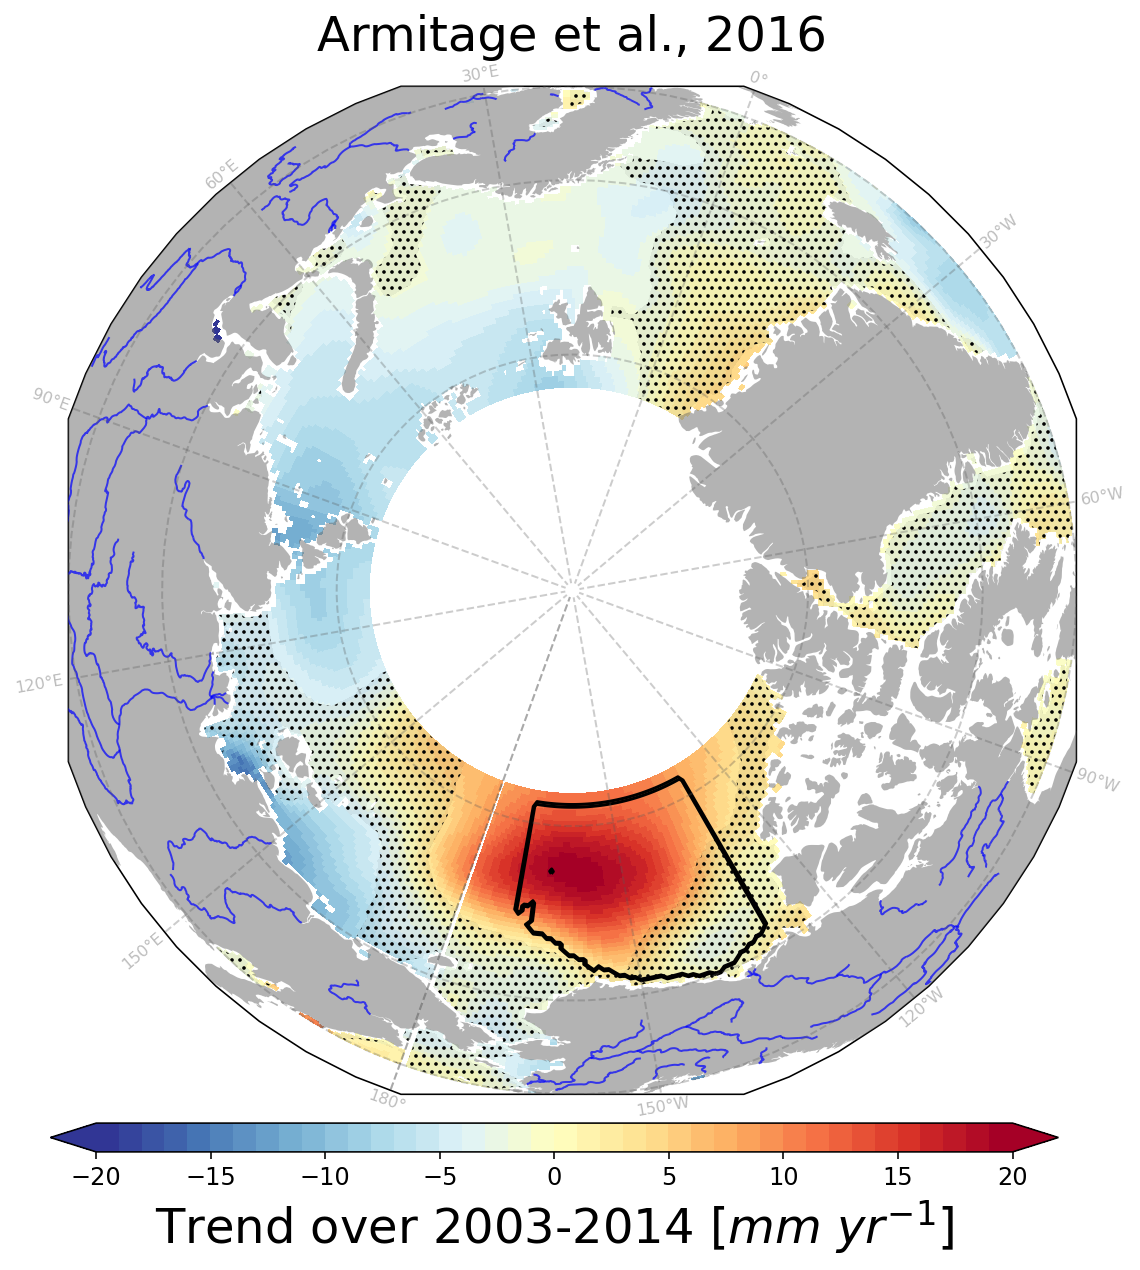

In [64]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

data2plot = (armi_Tr).squeeze()
cs  = axa.pcolormesh(longs, lats, data2plot,shading='flat',transform=trdata, cmap = mycm1,norm=norm1)
cs2_2= axa.contourf(longs, lats, armi_signi.where(armi_signi==1),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/']) # j'ai enlevé le .where(longs>0)
vectorize(cs2_2)
axa.contour(longs,lats,armi_BGRmask,1,colors="k",transform=trdata)

# significance
# cs2_1= axa.contourf(longs, lats,armi_signi.where(armi_signi==1).where(longs<0),transform=trdata, \
#                   colors='none',alpha=alphaHatch,hatches=['...'*1, '/'])
# vectorize(cs2_1)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

axa.set_title("Armitage et al., 2016", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='both', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)

cbar.set_label(r'Trend over 2003-2014 [$mm$ $yr^{-1}$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

# namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

## GAI

In [54]:
chunk_size = {"x":133,"y":320}
# plot directory

diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask.isel(nav_lev=0)
nav_lon = mesh_hgr.nav_lon
nav_lat = mesh_hgr.nav_lat

mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0) # grille lat/lon

BGRmask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc').BGRmask.squeeze()

In [55]:
tmask

<xarray.DataArray 'tmask' (y: 1207, x: 1442)>
dask.array<getitem, shape=(1207, 1442), dtype=int8, chunksize=(320, 133), chunktype=numpy.ndarray>
Coordinates:
    nav_lev       float32 0.5058
    time_counter  float64 0.0
Dimensions without coordinates: y, x

In [61]:
# p-value
gai_pval  = ds_linregress.sel(parameter='pvalue')
# slope
gai_trend = ds_linregress.sel(parameter='slope')

gai_signi = tmask.where(gai_pval > pval)


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


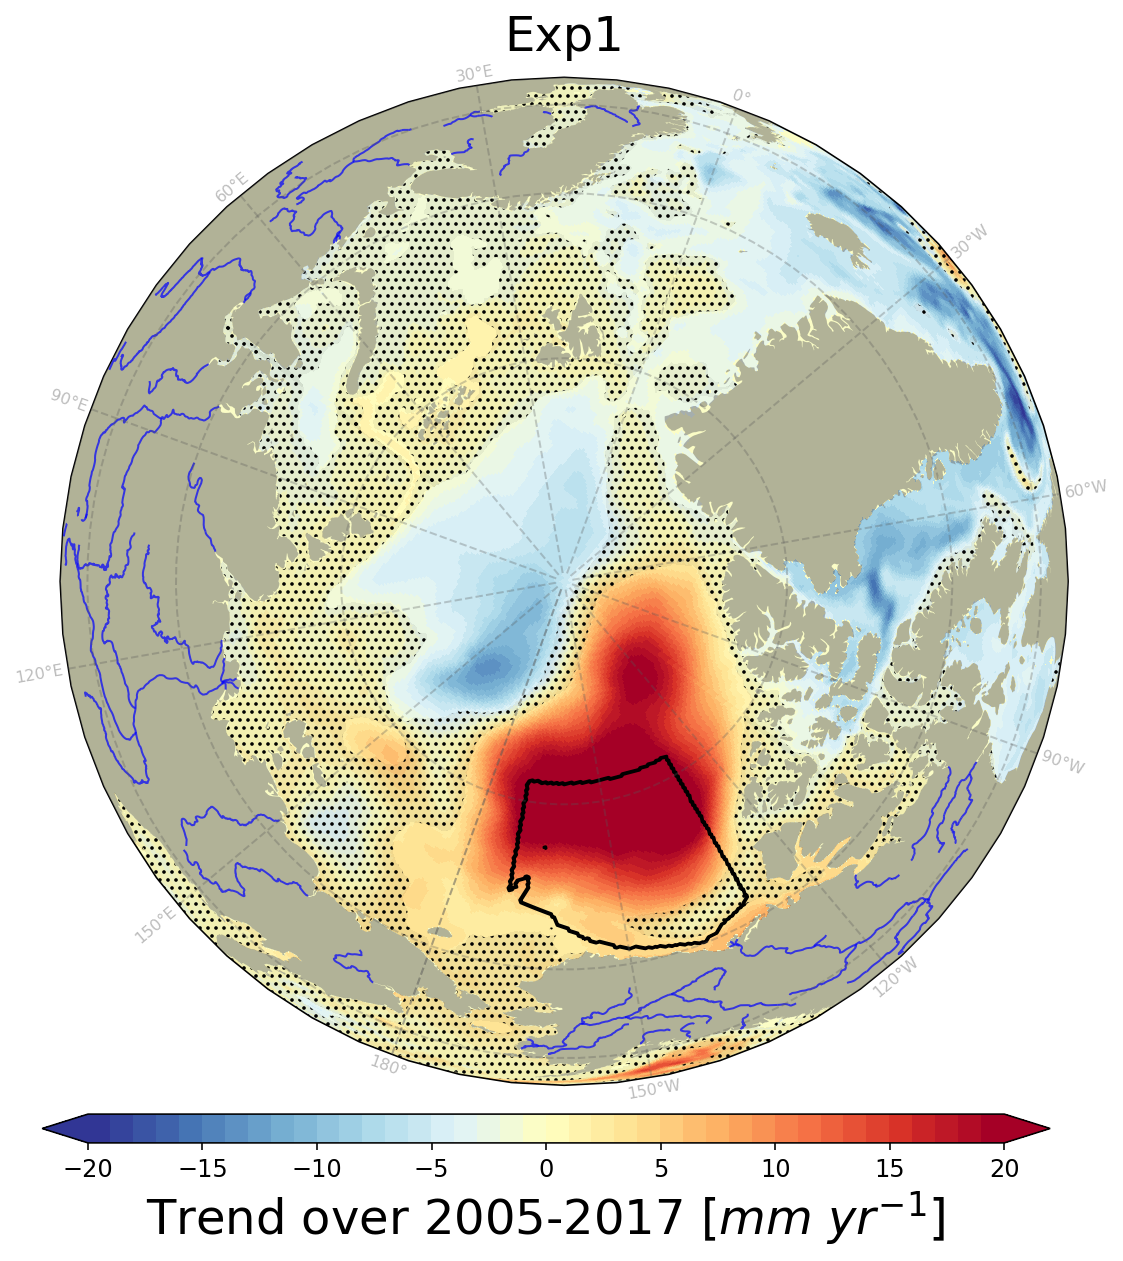

In [62]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

data2plot = (gai_trend).squeeze()
cs  = axa.pcolormesh(nav_lon,nav_lat, data2plot,shading='flat',transform=trdata, cmap = mycm1,norm=norm1)

cs2_2= axa.contourf(nav_lon,nav_lat, gai_signi.where(gai_signi==1).where(nav_lon>0),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/']) # j'ai enlevé le 
vectorize(cs2_2)

cs2_1= axa.contourf(nav_lon,nav_lat,gai_signi.where(gai_signi==1).where(nav_lon<0),transform=trdata, \
                  colors='none',alpha=alphaHatch,hatches=['...'*1, '/'])
vectorize(cs2_1)

axa.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

axa.set_title("Exp1", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='both', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)

cbar.set_label(r'Trend over 2005-2017 [$mm$ $yr^{-1}$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

# namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)